In [1]:
import healpy as hp
from astropy.io import fits
import numpy as np
import treecorr
import sys, os
sys.path.append('/mnt/home/spandey/ceph/esutil/esutil')
# import esutil.coords
import coords
import matplotlib
%matplotlib inline
import matplotlib.pyplot as pl






In [80]:
M_min = 1e14
M_max = 1e16
z_min = 0.2
z_max = 0.5


In [81]:
# len(M200m_websky)
def ang2eq(theta, phi):
    ra = phi * 180. / np.pi
    dec = 90. - theta * 180. / np.pi
    return ra, dec


def eq2ang(ra, dec):
    phi = ra * np.pi / 180.
    theta = (np.pi / 2.) - dec * (np.pi / 180.)
    return theta, phi

def get_zmean(zcent,delz,nz_bin):
    prob_zcent = nz_bin
    zmean = (np.sum(prob_zcent*zcent*delz))/(np.sum(prob_zcent*delz))
    return zmean




In [85]:
ldir = '/mnt/home/spandey/ceph/agora/'
all_ind = np.arange(0,176)
# all_ind
zall, vall, mall, ra_all, dec_all = [], [], [], [], []
from tqdm import tqdm
for ji in tqdm(range(len(all_ind))):
    try:
        df = np.load(ldir + 'halolc/haloslc_rot_' + str(ji+1) + '.npy')
        if np.any(df[:,2] < z_min):
            pass
        elif np.any(df[:,2] > z_max):
            break
        else:
            m200c = df[:,3]
            indsel = np.where((m200c > M_min) & (m200c < M_max))[0]
            zsel = df[:,2][indsel]
            vsel = df[:,7][indsel]
            rasel = df[:,0][indsel]
            decsel = df[:,1][indsel]   
            msel = m200c[indsel]
            zall.append(zsel)
            vall.append(vsel)
            ra_all.append(rasel)
            dec_all.append(decsel)
            mall.append(msel)
    except:
        pass
zall = np.hstack((zall))
mall = np.hstack((mall))
vall = np.hstack((vall))



 29%|██▉       | 51/176 [00:01<00:02, 43.56it/s] 


In [86]:
zall = np.hstack((zall))
mall = np.hstack((mall))
vall = np.hstack((vall))

print(len(zall))

99993


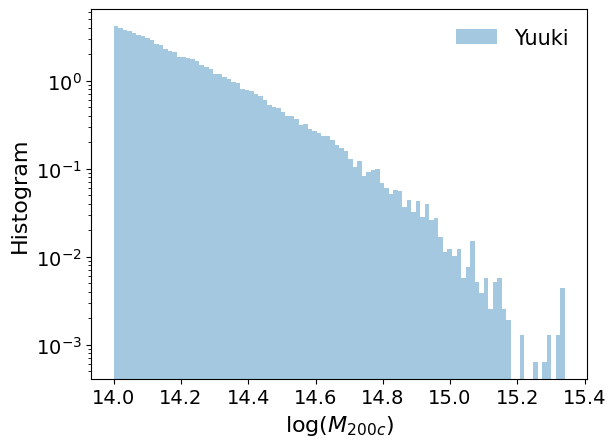

In [6]:
pl.figure()
_ = pl.hist(np.log10((mall)), bins=100, alpha=0.4, histtype='bar', density=True, label='Yuuki')
pl.yscale('log')
pl.legend(fontsize=15, frameon=False)
pl.xlabel(r'$\log(M_{200c})$', size=16)
pl.ylabel(r'Histogram', size=16)
pl.tick_params(axis='both', labelsize=14)




(1e-06, 0.003)

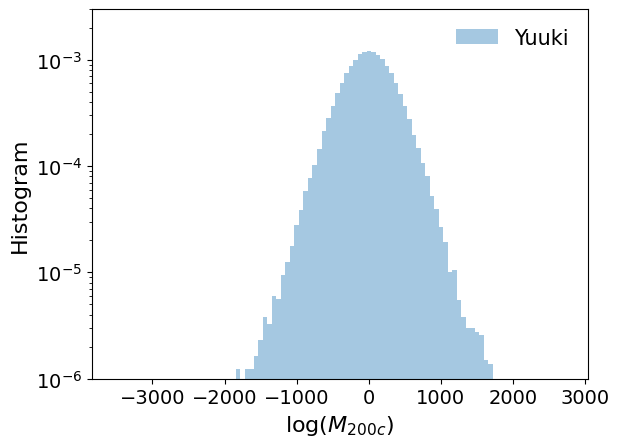

In [7]:
pl.figure()
_ = pl.hist(vall/1e3, bins=100, histtype='bar', alpha=0.4, density=True, label='Yuuki')
pl.yscale('log')
pl.legend(fontsize=15, frameon=False)
pl.xlabel(r'$\log(M_{200c})$', size=16)
pl.ylabel(r'Histogram', size=16)
pl.tick_params(axis='both', labelsize=14)
pl.ylim(1e-6, 3e-3)




In [8]:
# ksz_noiseless_tk
ksz_noiseless_yuuki = hp.read_map(ldir + 'ksz/mdpl2_lkszNG_bahamas76_rot_sum_4_176_bnd_unb_1.0e+12_1.0e+18_v103021_lmax24000_nside8192_interp1.6_method1_1_lensed_map.fits')
ksz_noiseless_yuuki = hp.ud_grade(ksz_noiseless_yuuki, 2048)



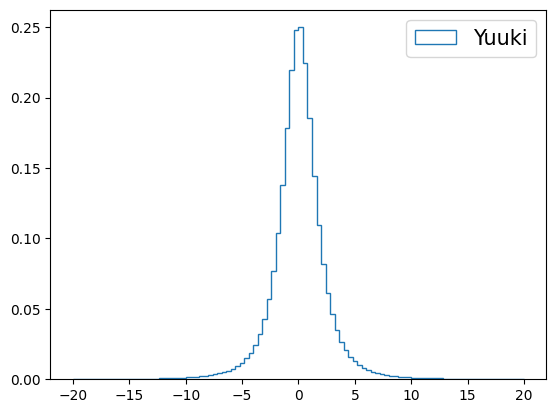

In [9]:
pl.figure()
_ = pl.hist(ksz_noiseless_yuuki, bins=100, histtype='step', range=(-20,20), density=True, label='Yuuki')
pl.legend(fontsize=15)



In [10]:
def ang2eq(theta, phi):
    ra = phi * 180. / np.pi
    dec = 90. - theta * 180. / np.pi
    return ra, dec


def eq2ang(ra, dec):
    phi = ra * np.pi / 180.
    theta = (np.pi / 2.) - dec * (np.pi / 180.)
    return theta, phi

def get_zmean(zcent,delz,nz_bin):
    prob_zcent = nz_bin
    zmean = (np.sum(prob_zcent*zcent*delz))/(np.sum(prob_zcent*delz))
    return zmean







In [11]:
datapoint_ra, datapoint_dec = np.hstack((ra_all)), np.hstack((dec_all))
datapoint_w = np.ones_like(datapoint_ra)
nrand = 5*len(datapoint_ra)
rand_ra, rand_dec = coords.randsphere(nrand, ra_range=[0,360], dec_range=[-90,90])
rand_w = np.ones_like(rand_ra)




In [50]:
do_jk = True
put_weights_datapoints = True
do_randy_sub = True
nthreads = 128
bin_slop = 0.05

minrad = 1.0
maxrad = 30.0    
nrad = 15
njk = 4096




In [51]:
# np.sqrt(40000/1024)
# area of sky in sq deg
area = 4*np.pi*(180/np.pi)**2
# number of patches = njk
# area of each patch
area_patch = area/njk
# side of each patch in arcmin
side_patch = np.sqrt(area_patch)*60
print(side_patch)



190.41398444736777


In [52]:
import sys, os
save_dir_jk = '/mnt/home/spandey/ceph/SZST/temp/'
save_filename_jk_obj = 'temp_jk_centers_njk' + str(njk)
if os.path.isfile(save_dir_jk + save_filename_jk_obj):
    datapoint_cat = treecorr.Catalog(ra=datapoint_ra, dec=datapoint_dec, w=datapoint_w, ra_units='degrees',
                                dec_units='degrees', patch_centers=save_dir_jk + save_filename_jk_obj)           

else:
    datapoint_cat = treecorr.Catalog(ra=datapoint_ra, dec=datapoint_dec, w=datapoint_w, ra_units='degrees',
                                    dec_units='degrees', npatch=njk)
    datapoint_cat.write_patch_centers(save_dir_jk + save_filename_jk_obj)
rand_cat = treecorr.Catalog(ra=rand_ra, dec=rand_dec, w=rand_w, ra_units='degrees', dec_units='degrees', patch_centers=save_dir_jk + save_filename_jk_obj)




In [38]:
ksz_noiseless = hp.read_map(ldir + 'ksz/mdpl2_lkszNG_bahamas76_rot_sum_4_176_bnd_unb_1.0e+12_1.0e+18_v103021_lmax24000_nside8192_interp1.6_method1_1_lensed_map.fits')
ksz_noiseless = hp.ud_grade(ksz_noiseless, 2048)




In [39]:
ksz_noise = np.random.randn(len(ksz_noiseless)) * (10*np.std(ksz_noiseless))



In [40]:
ksz = ksz_noiseless + ksz_noise


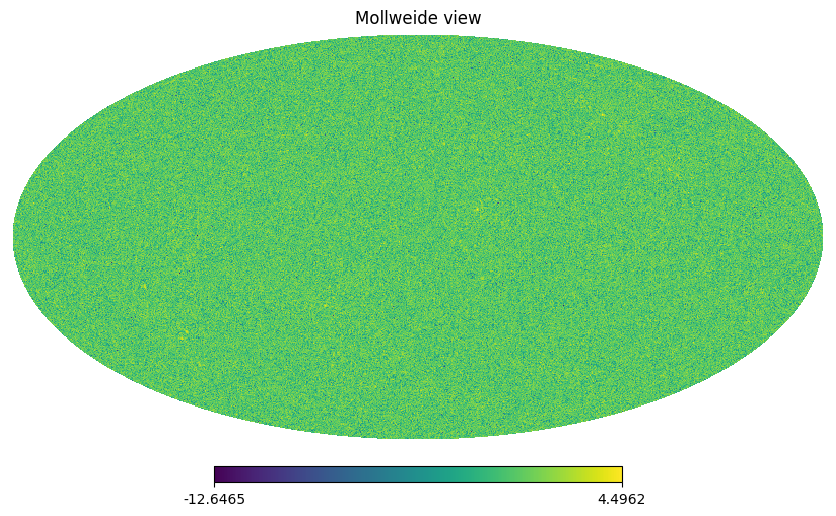

In [17]:
hp.mollview(np.log(np.abs(ksz_noiseless)))



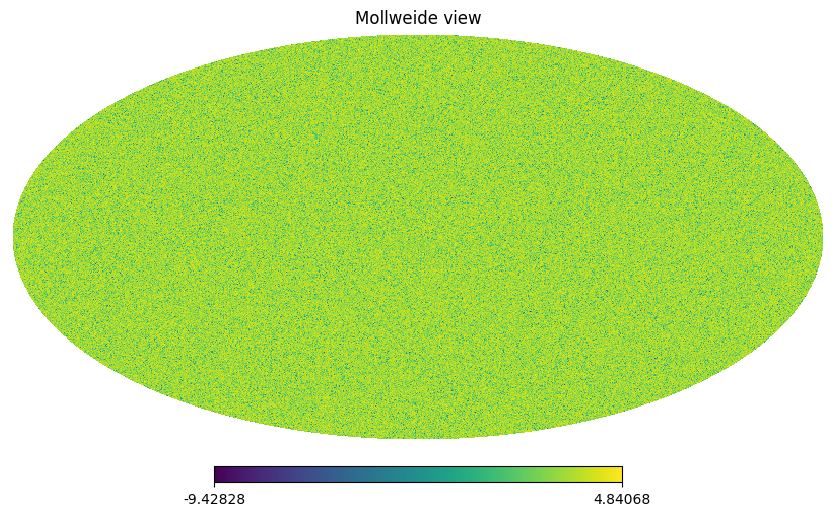

In [18]:
hp.mollview(np.log(np.abs(ksz)))


In [19]:
# np.mean(ksz)


In [53]:
npix_ksz = len(ksz)
nside_ksz = hp.npix2nside(npix_ksz)
pix_theta, pix_phi = hp.pix2ang(nside_ksz, np.arange(npix_ksz))
pix_ra, pix_dec = ang2eq(pix_theta, pix_phi)




In [54]:
# ra_y, dec_y, ymap_truth = np.array(rad2deg * ras.flatten()), np.array(rad2deg * decs.flatten()), np.array(imapy.flatten())    
ytruth_cat = treecorr.Catalog(ra=pix_ra, dec=pix_dec, k=ksz, ra_units='degrees', dec_units='degrees')

dytruth = treecorr.NKCorrelation(nbins=nrad, min_sep=minrad, max_sep=maxrad, sep_units='arcmin', verbose=0,num_threads=nthreads, bin_slop=bin_slop, var_method='jackknife')
randytruth = treecorr.NKCorrelation(nbins=nrad, min_sep=minrad, max_sep=maxrad, sep_units='arcmin', verbose=0,num_threads=nthreads, bin_slop=bin_slop, var_method='jackknife')

print('doing dataxy calculation')
dytruth.process(datapoint_cat, ytruth_cat)

print('doing randomxy calculation')
randytruth.process(rand_cat, ytruth_cat)
dytruth.calculateXi(rk=randytruth)

xi_dy_full = dytruth.xi
r_dy = np.exp(dytruth.meanlogr)
cov_dy = dytruth.cov
sig_dy = np.sqrt(np.diag(cov_dy))
# print(




doing dataxy calculation
doing randomxy calculation


In [55]:
print(np.sqrt(np.dot(xi_dy_full, np.dot(np.linalg.inv(cov_dy), xi_dy_full))))
      
    

4.15292700033244


In [56]:
# ra_y, dec_y, ymap_truth = np.array(rad2deg * ras.flatten()), np.array(rad2deg * decs.flatten()), np.array(imapy.flatten())    
ytruth_cat2 = treecorr.Catalog(ra=pix_ra, dec=pix_dec, k=ksz**2, ra_units='degrees', dec_units='degrees')

dytruth2 = treecorr.NKCorrelation(nbins=nrad, min_sep=minrad, max_sep=maxrad, sep_units='arcmin', verbose=0,num_threads=nthreads, bin_slop=bin_slop, var_method='jackknife')
randytruth2 = treecorr.NKCorrelation(nbins=nrad, min_sep=minrad, max_sep=maxrad, sep_units='arcmin', verbose=0,num_threads=nthreads, bin_slop=bin_slop, var_method='jackknife')

print('doing dataxy calculation')
dytruth2.process(datapoint_cat, ytruth_cat2)

print('doing randomxy calculation')
randytruth2.process(rand_cat, ytruth_cat2)
dytruth2.calculateXi(rk=randytruth2)

xi_dy_full2 = dytruth2.xi
r_dy2 = np.exp(dytruth2.meanlogr)
cov_dy2 = dytruth2.cov
sig_dy2 = np.sqrt(np.diag(cov_dy2))



doing dataxy calculation
doing randomxy calculation


In [57]:
print(np.sqrt(np.dot(xi_dy_full2, np.dot(np.linalg.inv(cov_dy2), xi_dy_full2))))
      
    

18.52062592755101


In [58]:
# ra_y, dec_y, ymap_truth = np.array(rad2deg * ras.flatten()), np.array(rad2deg * decs.flatten()), np.array(imapy.flatten())    
ytruth_cat_abs = treecorr.Catalog(ra=pix_ra, dec=pix_dec, k=np.abs(ksz), ra_units='degrees', dec_units='degrees')

dytruth_abs = treecorr.NKCorrelation(nbins=nrad, min_sep=minrad, max_sep=maxrad, sep_units='arcmin', verbose=0,num_threads=nthreads, bin_slop=bin_slop, var_method='jackknife')
randytruth_abs = treecorr.NKCorrelation(nbins=nrad, min_sep=minrad, max_sep=maxrad, sep_units='arcmin', verbose=0,num_threads=nthreads, bin_slop=bin_slop, var_method='jackknife')

print('doing dataxy calculation')
dytruth_abs.process(datapoint_cat, ytruth_cat_abs)

print('doing randomxy calculation')
randytruth_abs.process(rand_cat, ytruth_cat_abs)
dytruth_abs.calculateXi(rk=randytruth_abs)

xi_dy_full_abs = dytruth_abs.xi
r_dy_abs = np.exp(dytruth_abs.meanlogr)
cov_dy_abs = dytruth_abs.cov
sig_dy_abs = np.sqrt(np.diag(cov_dy_abs))



doing dataxy calculation
doing randomxy calculation


In [59]:
print(np.sqrt(np.dot(xi_dy_full_abs, np.dot(np.linalg.inv(cov_dy_abs), xi_dy_full_abs))))




17.361074547743044


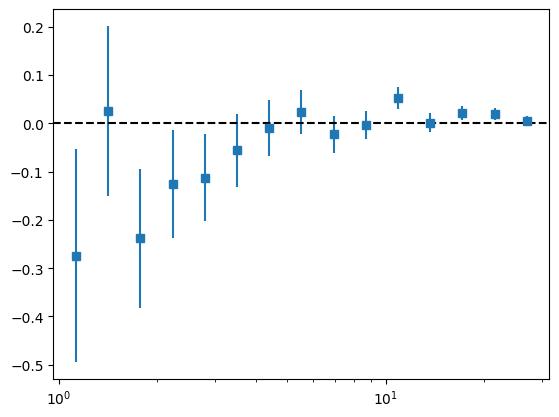

In [60]:
# xi_dy_full_abs
pl.figure()
pl.errorbar(r_dy, xi_dy_full, sig_dy, ls='', marker='s')
pl.axhline(0, ls='--', color='k')
# pl.errorbar(r_dy_abs*1.05, xi_dy_full2, sig_dy2, ls='', marker='o')
pl.xscale('log')
# pl.yscale('log')




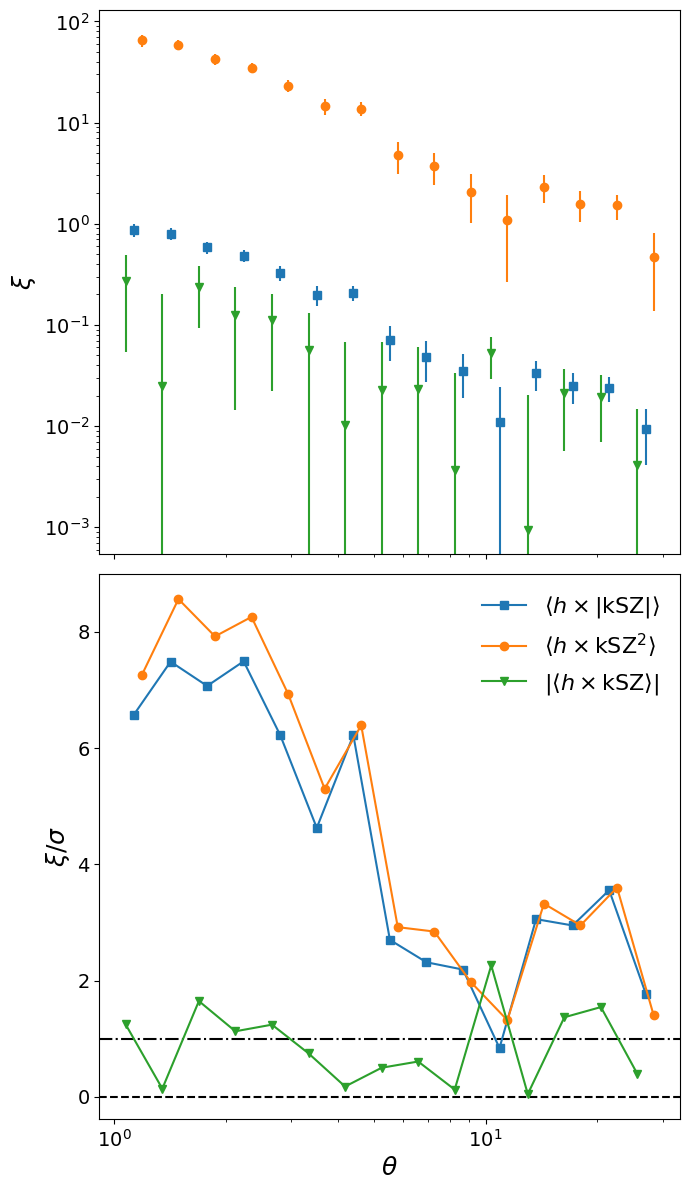

In [65]:
import matplotlib.pyplot as plt

# create the first subplot
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(7, 12))
plt.subplots_adjust(hspace=0.05)
ax1.errorbar(r_dy_abs, xi_dy_full_abs, sig_dy_abs, ls='', marker='s', label=r'$\langle h \times |\rm{kSZ}| \rangle$')
ax1.errorbar(r_dy_abs*1.05, xi_dy_full2, sig_dy2, ls='', marker='o', label=r'$\langle h  \times \rm{kSZ}^2 \rangle$')
ax1.errorbar(0.95*r_dy, np.abs(xi_dy_full), sig_dy, ls='', marker='v', label=r'$|\langle h  \times \rm{kSZ} \rangle|$')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.tick_params(axis='both', labelsize=14)
# ax1.legend(fontsize=16, frameon=False)
ax1.set_ylabel(r'$\xi$', size=18)

# create the second subplot
ax2.errorbar(r_dy_abs, xi_dy_full_abs/sig_dy_abs, ls='-', marker='s', label=r'$\langle h \times |\rm{kSZ}| \rangle$')
ax2.errorbar(r_dy_abs*1.05, xi_dy_full2/sig_dy2, ls='-', marker='o', label=r'$\langle h  \times \rm{kSZ}^2 \rangle$')
ax2.errorbar(0.95*r_dy, np.abs(xi_dy_full)/sig_dy, ls='-', marker='v', label=r'$|\langle h  \times \rm{kSZ} \rangle|$')
ax2.axhline(0.0, ls='--', color='k')
ax2.axhline(1.0, ls='-.', color='k')
ax2.set_xscale('log')
ax2.tick_params(axis='both', labelsize=14)
ax2.legend(fontsize=16, frameon=False)
ax2.set_xlabel(r'$\theta$', size=18)
ax2.set_ylabel(r'$\xi/\sigma$', size=18)

# display the plot
# plt.show()
plt.tight_layout()
# plt.savefig('ksz_yuuki_cross_halos_Mgt_' + '1e14' + '_zlt_0p5' + '_noiseless.pdf')
# plt.savefig('ksz_yuuki_cross_halos_Mgt_' + '1e14' + '_zlt_0p5' + '_10signoise.pdf')
# plt.savefig('ksz_cross_halos_Mgt_' + '1e14' + '_zlt_0p5' + '_websky.pdf')




In [69]:
def get_corr(cov):
    v = np.sqrt(np.diag(cov))
    outer_v = np.outer(v, v)
    corr = cov / outer_v
    return corr


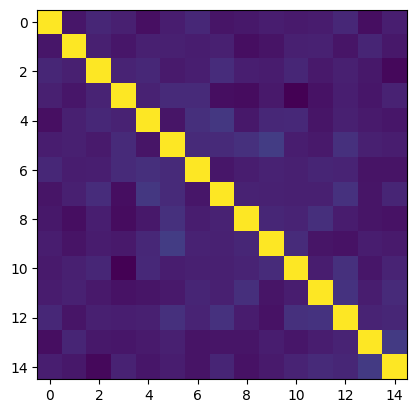

In [70]:
pl.figure()
# pl.imshow(np.log(np.abs(cov_dy2)))
pl.imshow(get_corr(cov_dy2))


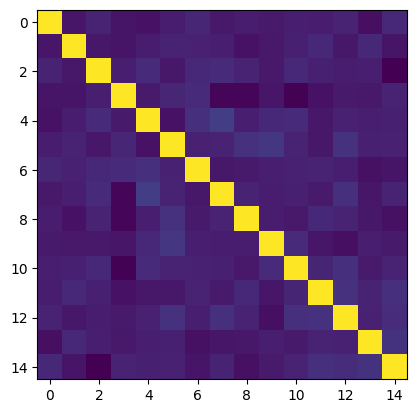

In [71]:
pl.figure()
# pl.imshow(np.log(np.abs(cov_dy_abs)))
pl.imshow(get_corr(cov_dy_abs))


In [32]:
nestpix = hp.ang2pix(2048,datapoint_ra, datapoint_dec,nest=True,lonlat=True)
pix = nestpix
pix.sort()
first = np.where(pix[:-1] != pix[1:])[0] + 1
first = np.concatenate(([0],first))
hpix = pix[first]
cts = np.diff(first,append=len(pix))
m = np.zeros(hp.nside2npix(2048),dtype=int)
m[hpix] = cts
density_halo = -1 + m/np.mean(m)
density_halo = hp.reorder(density_halo, n2r=True)


In [49]:
# hp.mollview(np.log(1.001 + density_halo), nest=True)
hp.write_map('takahashi_density_halo_Mgt_5e13_zlt_0p5_ns2048.fits', density_halo)



setting the output map dtype to [dtype('float64')]


In [50]:
hp.write_map('takahashi_ksz_wnoise_3sigma_ns2048.fits', ksz)



setting the output map dtype to [dtype('float64')]


In [37]:
Cls_ksz_h = hp.anafast(density_halo, ksz)
Cls_absksz_h = hp.anafast(density_halo, np.abs(ksz))
Cls_ksz2_h = hp.anafast(density_halo, (ksz)**2)
ells = np.arange(len(Cls_ksz_h))




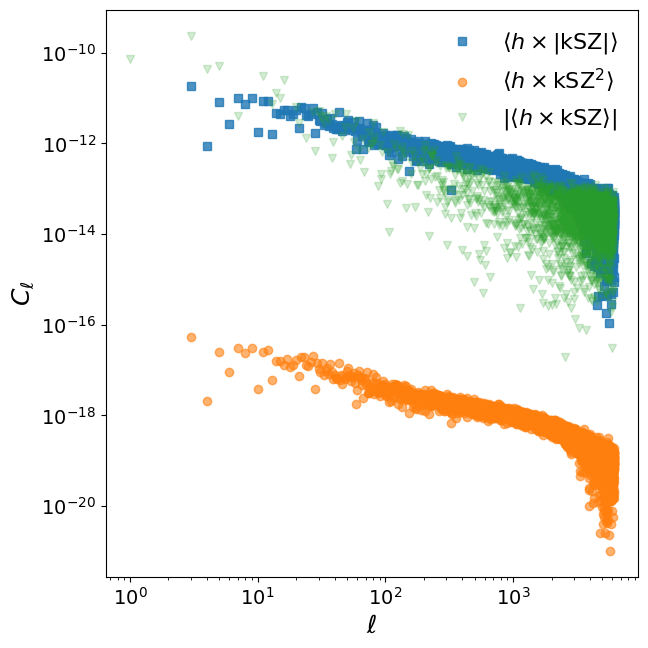

In [47]:
pl.figure()
pl.plot(ells, Cls_absksz_h, ls='', alpha=0.8, marker='s', label=r'$\langle h \times |\rm{kSZ}| \rangle$')
pl.plot(ells, Cls_ksz2_h, ls='', alpha=0.6, marker='o', label=r'$\langle h  \times \rm{kSZ}^2 \rangle$')
pl.plot(ells, Cls_ksz_h, ls='', alpha=0.2, marker='v', label=r'$|\langle h  \times \rm{kSZ} \rangle|$')
pl.xscale('log')
pl.yscale('log')
# pl.set_xscale('log')
# pl.set_yscale('log')
pl.tick_params(axis='both', labelsize=14)
pl.legend(fontsize=16, frameon=False)
pl.ylabel(r'$C_{\ell}$', size=18)
pl.xlabel(r'${\ell}$', size=18)
# pl.ylim(1e-6, 1e-3)
pl.tight_layout()
pl.savefig('harmonic_ksz_cross_halos_Mgt_' + '5e13' + '_zlt_0p5' + '_3signoise.pdf')



(1e-06, 0.001)

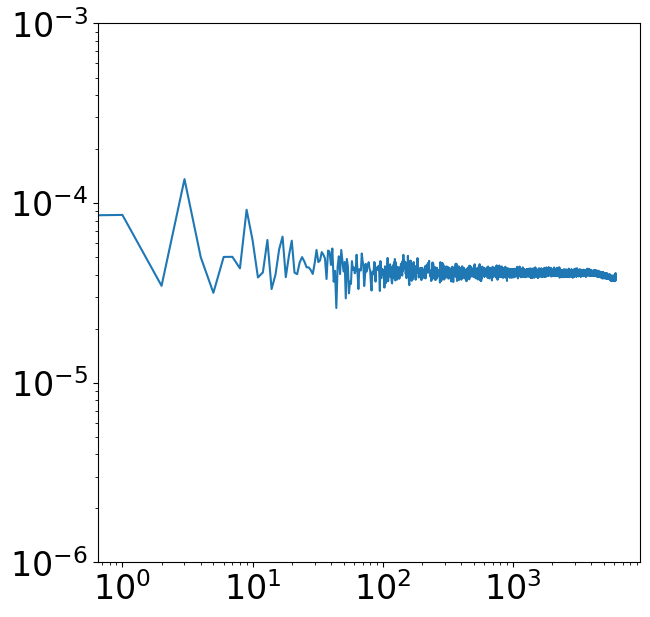

In [47]:
pl.figure()
pl.plot(ells, Cls)
pl.xscale('log')
pl.yscale('log')
pl.ylim(1e-6, 1e-3)



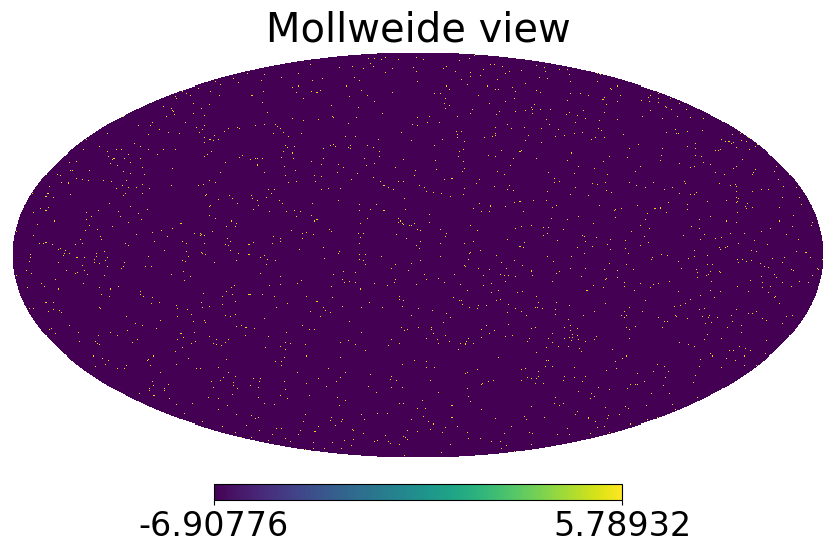

findfont: Generic family 'serif' not found because none of the following families were found: Palatino
findfont: Generic family 'serif' not found because none of the following families were found: Palatino


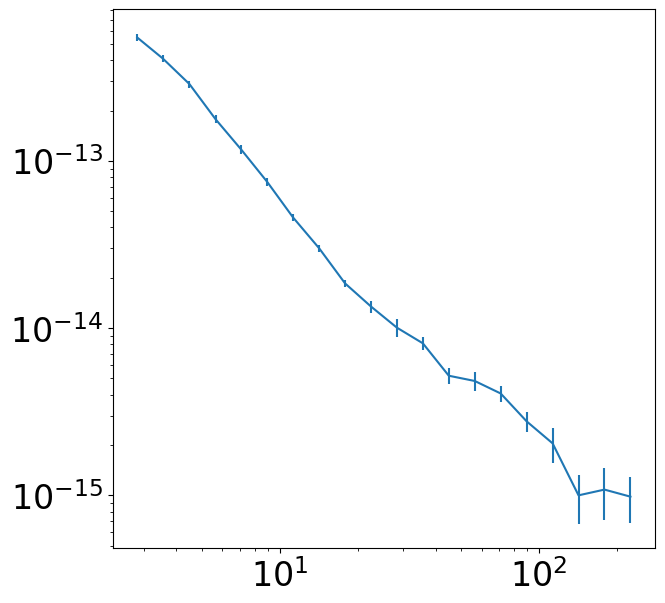

In [47]:
# xi_dy_full_abs
pl.figure()
pl.errorbar(r_dy_abs, xi_dy_full2, sig_dy2)
pl.xscale('log')
pl.yscale('log')




In [48]:
# df = hp.read_map('/global/cfs/cdirs/lsst/www/shivamp/ksz_test/allsky_HP_kSZ_nres13_r000.fits')
# ksz = hp.ud_grade(df, 1024)
# # print(hp.npix2nside(len(df)))
# # hp.mollview(np.log(np.abs(df_ud)))



129602594


30185


In [6]:
datapoint_ra, datapoint_dec = ang2eq(theta_i[indsel], phi_i[indsel])
datapoint_w = np.ones_like(datapoint_ra)
nrand = 10*len(datapoint_ra)
rand_ra, rand_dec = esutil.coords.randsphere(nrand, ra_range=[0,360], dec_range=[-90,90])
rand_theta, rand_phi = eq2ang(rand_ra, rand_dec)
rand_w = np.ones_like(rand_ra)




In [9]:
# ra_y, dec_y, ymap_truth = np.array(rad2deg * ras.flatten()), np.array(rad2deg * decs.flatten()), np.array(imapy.flatten())    
ytruth_cat = treecorr.Catalog(ra=pix_ra, dec=pix_dec, k=ksz, ra_units='degrees', dec_units='degrees')

dytruth = treecorr.NKCorrelation(nbins=nrad, min_sep=minrad, max_sep=maxrad, sep_units='arcmin', verbose=0,num_threads=nthreads, bin_slop=bin_slop, var_method='jackknife')
randytruth = treecorr.NKCorrelation(nbins=nrad, min_sep=minrad, max_sep=maxrad, sep_units='arcmin', verbose=0,num_threads=nthreads, bin_slop=bin_slop, var_method='jackknife')

print('doing dataxy calculation')
dytruth.process(datapoint_cat, ytruth_cat)

print('doing randomxy calculation')
randytruth.process(rand_cat, ytruth_cat)
dytruth.calculateXi(rk=randytruth)

xi_dy_full = dytruth.xi
r_dy = np.exp(dytruth.meanlogr)
cov_dy = dytruth.cov
sig_dy = np.sqrt(np.diag(cov_dy))
print(xi_dy_full)




NameError: name 'pix_ra' is not defined

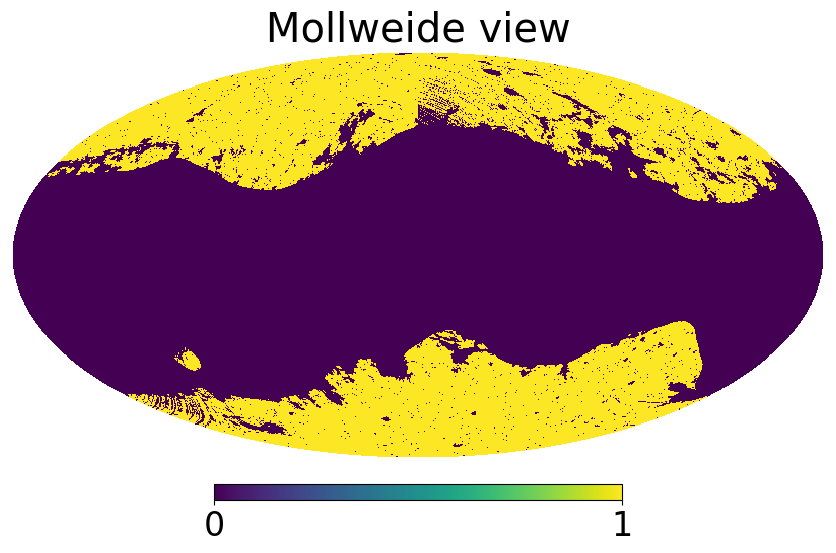

In [1]:
# More specifically, we recommend using
# thresholds of 2.5×1020 cm−2 (353 GHz), 2.0×1020 cm−2 (545
# GHz), and 1.8×1020 cm−2 (857 GHz)
import healpy as hp
from astropy.io import fits
import numpy as np
import treecorr
import esutil
# from pixell import utils, bunch
# import numpy as np, pyccl, time
# import pyccl
import matplotlib
%matplotlib inline
import matplotlib.pyplot as pl
pl.rcParams.update({
    "text.usetex": False,
    "font.family": "DejaVu Sans"
})



# 353
df = hp.read_map('/global/cfs/cdirs/des/shivamp/ACTxDESY3_data/planck_data/lenz17/545/mask_bool.fits')
hp.mollview(df)
# hp.npix2nside(len(df))



In [2]:
r = hp.Rotator(coord=['G','C'])
df_rotated = r.rotate_map_alms(df)



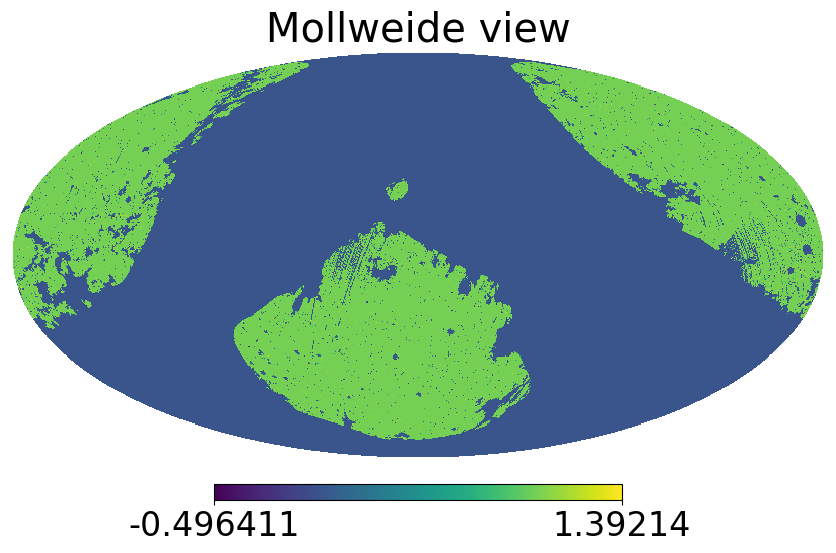

In [3]:
hp.mollview(df_rotated)



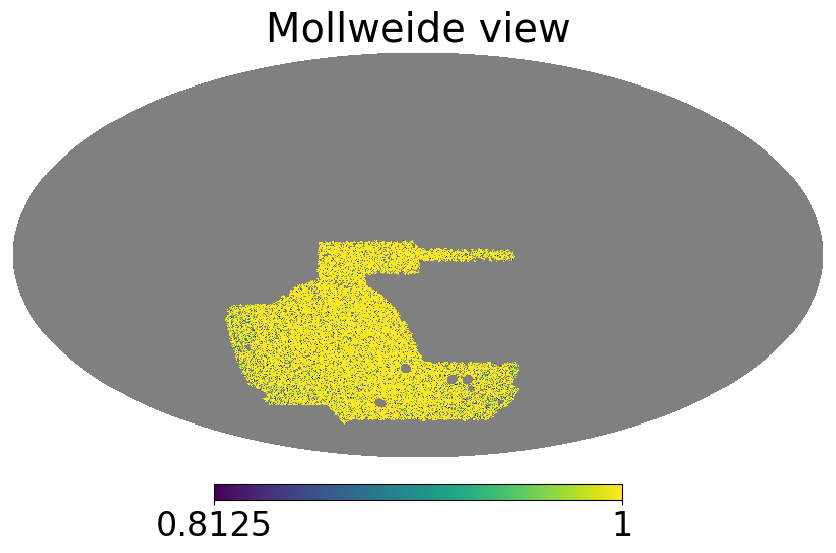

In [17]:
mask_des = hp.read_map('/global/cfs/cdirs/des/data_actxdes/des_data/y3_gold_2.2.1_RING_joint_redmagic_v0.5.1_wide_maglim_v2.2_mask.fits.gz', partial=True)
hp.mollview(mask_des)



In [8]:
indsel = np.where(df_rotated > 0.1)[0]
df_rotated[indsel] = 1.

indsel = np.where(df_rotated < 0.1)[0]
df_rotated[indsel] = 0.



In [19]:
# mask_des = hp.ud_grade(mask_des, 2048)

# indsel = np.where(mask_des > 0.1)[0]
# mask_des[indsel] = 1.

# indsel = np.where(mask_des < 0.1)[0]
# mask_des[indsel] = 0.



In [23]:
mask_f = hp.read_map('/global/cfs/cdirs/des/data_actxdes/mask_updated_ACTDR6xDESY3.fits')
# nside = 2048
nside = 4096

mask_des = hp.ud_grade(mask_f, 2048)

indsel = np.where(mask_des > 0.1)[0]
mask_des[indsel] = 1.

indsel = np.where(mask_des < 0.1)[0]
mask_des[indsel] = 0.


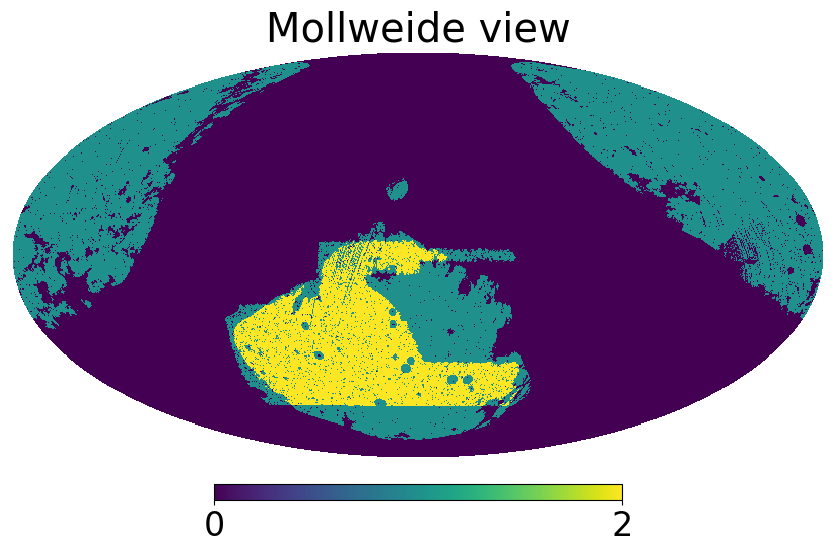

In [24]:
hp.mollview(df_rotated+mask_des)



In [25]:
indsel = np.where(df_rotated+mask_des == 2)[0]



In [26]:
print(len(indsel) * hp.nside2pixarea(2048, degrees=True))



3516.269084351507


In [14]:
hp.nside2pixarea(2048, degrees=True)*(60**2)


2.9506417214455083